# Fast Gradient Sign Method

- Author: Tootouch (Jaehyuk Heo)

- Explaining and Harnessing Adversarial Examples [ [paper](https://arxiv.org/abs/1412.6572) ]
- torchattacks [ [doc](https://adversarial-attacks-pytorch.readthedocs.io/en/latest/attacks.html) ]

![image](https://user-images.githubusercontent.com/37654013/136537549-e31ba553-67ce-43b5-ad36-479e4fb9021d.png)

In [1]:
# pip install torchattacks
# pip install timm

In [2]:
from torchattacks.attack import Attack

import timm

from timm.data import create_loader, create_dataset
from timm.data.transforms import _pil_interp

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time

from tqdm.auto import tqdm

In [3]:
class Config:
    dataset      = 'Imagenet'
    data         = '/datasets/Imagenet/ILSVRC/Data/CLS-LOC/'
    split        = 'val'
    img_size     = 224
    batch_size   = 512
    num_workers  = 8
    
args = Config()

# Build Model

In [4]:
model = timm.create_model('resnet50', pretrained=True)

# Load Data

In [5]:
def transforms_imagenet_eval(img_size, crop_pct, interpolation):

    # scaling image for cropping
    if isinstance(img_size, (tuple, list)):
        assert len(img_size) == 2
        if img_size[-1] == img_size[-2]:
            # fall-back to older behaviour so Resize scales to shortest edge if target is square
            scale_size = int(math.floor(img_size[0] / crop_pct))
        else:
            scale_size = tuple([int(x / crop_pct) for x in img_size])
    else:
        scale_size = int(math.floor(img_size / crop_pct))

    # transforms list
    tfl = [
        transforms.Resize(scale_size, _pil_interp(interpolation)),
        transforms.CenterCrop(img_size),
        transforms.ToTensor()
    ]

    return transforms.Compose(tfl)

In [6]:
transform_eval = transforms_imagenet_eval(
    img_size      = args.img_size,
    crop_pct      = model.default_cfg['crop_pct'],
    interpolation = model.default_cfg['interpolation']
)

In [7]:
dataset = create_dataset(root=args.data, name=args.dataset, split=args.split)
dataset.transform = transform_eval

In [8]:
args.batch_size = 16

loader = DataLoader(dataset, batch_size=args.batch_size, num_workers=args.num_workers)

# Normalize

In [9]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.view(1, 3, 1, 1)
        std = self.std.view(1, 3, 1, 1)
        return (input - mean) / std
    
model = nn.Sequential(
    Normalize(mean=model.default_cfg['mean'], std=model.default_cfg['std']),
    model
).cuda()

# Evaluation

In [9]:
criterion = nn.CrossEntropyLoss()

In [21]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:k].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

def validate(model, loader, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    model.eval()
    with torch.no_grad():
        end = time.time()
        for batch_idx, (input, target) in enumerate(loader):
            target = target.cuda()
            input = input.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output.detach(), target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1.item(), input.size(0))
            top5.update(acc5.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        
    print(
        'Time: {batch_time.sum:.3f}s ({batch_time.avg:.3f}s, {rate_avg:>6.2f}/s) '
        'Loss: {loss.avg:>6.4f} '
        'Acc@1: {top1.avg:>7.3f} '
        'Acc@5: {top5.avg:>7.3f}'.format(
        batch_time=batch_time,
        rate_avg=input.size(0) / batch_time.avg,
        loss=losses, top1=top1, top5=top5)
    )
    
    return batch_time, losses, top1, top5

In [22]:
batch_time, losses, top1, top5 = validate(model, loader, criterion)

Time: 71.763s (0.023s, 696.73/s) Loss: 1.0519 Acc@1:  78.602 Acc@5:  94.240


# FGSM

**FGSM(Fast Gradient Sign Method)**

$$x+\epsilon(\nabla_x L(\delta, x, y))$$

In [10]:
class FGSM(Attack):
    r"""
    FGSM in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]
    Distance Measure : Linf
    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 0.007)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.FGSM(model, eps=0.007)
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, model, eps=0.007):
        super().__init__("FGSM", model)
        self.eps = eps
        self._supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self._targeted:
            target_labels = self._get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        images.requires_grad = True
        outputs = self.model(images)

        # Calculate loss
        if self._targeted:
            cost = -loss(outputs, target_labels)
        else:
            cost = loss(outputs, labels)

        # Update adversarial images
        grad = torch.autograd.grad(cost, images,
                                   retain_graph=False, create_graph=False)[0]

        adv_images = images + self.eps*grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

In [11]:
atk = FGSM(model, eps=8/255)

In [12]:
loader = DataLoader(dataset, batch_size=32, num_workers=args.num_workers)

In [13]:
print("Adversarial Image & Predicted Label")
    
print("-"*70)
print(atk)

correct = 0
total = 0

start = time.time()
model.eval()
for images, labels in tqdm(loader):

    adv_images = atk(images, labels)
    labels = labels.cuda()
    outputs = model(adv_images)

    _, pre = torch.max(outputs.data, 1)

    total += images.size(0)
    correct += (pre == labels).sum()

print('Total elapsed time (sec): %.2f' % (time.time() - start))
print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

Adversarial Image & Predicted Label
----------------------------------------------------------------------
FGSM(model_name=Sequential, device=cuda:0, eps=0.03137254901960784, attack_mode=default, return_type=float)



Total elapsed time (sec): 212.16
Robust accuracy: 23.71 %


# Adversarial Example

In [77]:
import json 
idx_to_class = json.load(open('../imagenet_class_index.json','r'))

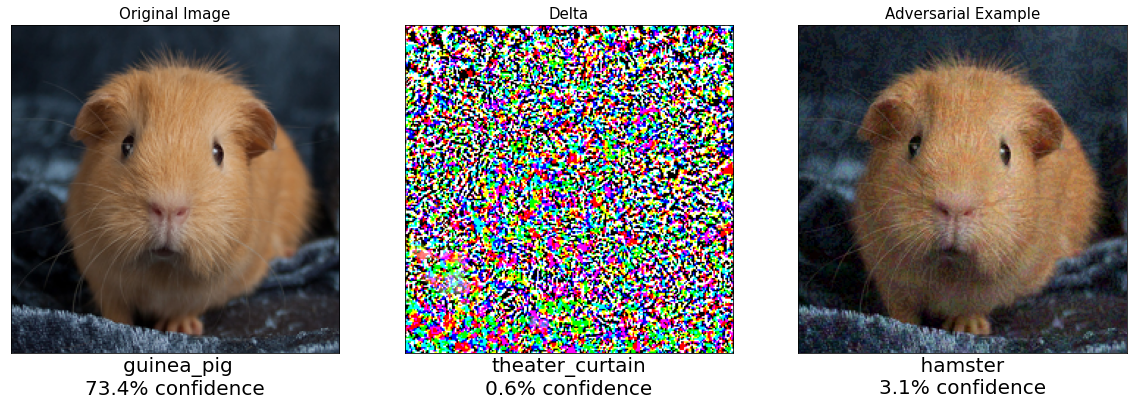

In [146]:
sample, label = dataset[16919]
adv_image = atk(sample.unsqueeze(0), torch.tensor([label]))
delta = adv_image.squeeze().cpu() - sample
delta = ((delta / delta.max()) + 1) / 2

model.eval()
output = model(sample.unsqueeze(0).cuda())
prob, pred = nn.functional.softmax(output, dim=1).max(1)
pred_classname = idx_to_class[str(pred.item())][1]

fig, ax = plt.subplots(1,3,figsize=(20,10))
ax[0].imshow(sample.permute(1,2,0))
ax[0].set_title('Original Image', size=15)
ax[0].set_xlabel("{0:}\n{1:.1%} confidence".format(pred_classname.center(15,' '), prob.item()), size=20)

output = model(delta.unsqueeze(0).cuda())
prob, pred = nn.functional.softmax(output, dim=1).max(1)
pred_classname = idx_to_class[str(pred.item())][1]

ax[1].imshow(delta.permute(1,2,0))
ax[1].set_title('Delta', size=15)
ax[1].set_xlabel("{0:}\n{1:.1%} confidence".format(pred_classname.center(15,' '), prob.item()), size=20)

output = model(adv_image)
prob, pred = nn.functional.softmax(output, dim=1).max(1)
pred_classname = idx_to_class[str(pred.item())][1]

ax[2].imshow(adv_image.squeeze().cpu().permute(1,2,0))
ax[2].set_title('Adversarial Example', size=15)
ax[2].set_xlabel("{0:}\n{1:.1%} confidence".format(pred_classname.center(15,' '), prob.item()), size=20)

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Experiments

terminal 에서 아래 명령어 실행

```bash
sh run.sh

```

In [147]:
exp = pd.read_csv('./fgsm_exp.csv')

In [148]:
exp

,epsilon,loss,top1-acc,top5-acc
0,0.001,2.137537,55.804,83.650
1,0.003,3.152612,38.874,70.886
2,0.005,3.588734,32.688,64.808
3,0.010,4.004905,26.908,58.022
4,0.030,4.180072,23.700,53.090
5,0.050,4.140231,23.898,52.132
6,0.100,4.278949,22.294,47.288


Text(0, 0.5, 'Acc@5')

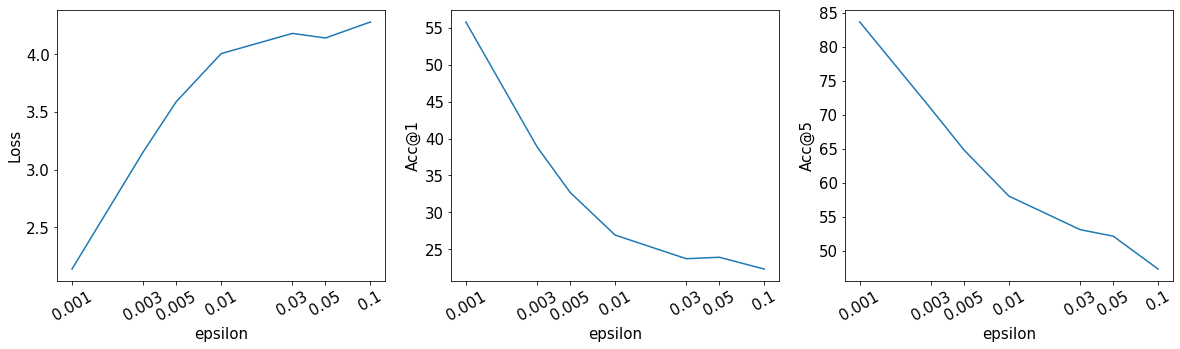

In [149]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].plot(np.log(exp.epsilon), exp.loss)
ax[0].set_xticks(np.log(exp.epsilon))
ax[0].set_xticklabels(exp.epsilon.astype(str), size=15, rotation=30)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_xlabel('epsilon', size=15)
ax[0].set_ylabel('Loss', size=15)

ax[1].plot(np.log(exp.epsilon), exp['top1-acc'])
ax[1].set_xticks(np.log(exp.epsilon))
ax[1].set_xticklabels(exp.epsilon.astype(str), size=15, rotation=30)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_xlabel('epsilon', size=15)
ax[1].set_ylabel('Acc@1', size=15)

ax[2].plot(np.log(exp.epsilon), exp['top5-acc'])
ax[2].set_xticks(np.log(exp.epsilon))
ax[2].set_xticklabels(exp.epsilon.astype(str), size=15, rotation=30)
ax[2].tick_params(axis='y', labelsize=15)
ax[2].set_xlabel('epsilon', size=15)
ax[2].set_ylabel('Acc@5', size=15)